# Import libraries

In [1]:
!nvidia-smi

Wed Aug 27 12:38:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:68:00.0 Off |                  N/A |
|  0%   38C    P8             16W /  350W |       2MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q transformers
!pip install -q ultralytics
!pip install -q faiss-cpu
!pip install -q torch
!pip install -q peft

In [2]:
import os
import torch
from PIL import Image
from IPython.display import display
import faiss
import numpy as np
import json
import glob
from ultralytics import YOLO
from transformers import pipeline, AutoModel
import re
from collections import defaultdict

# Model setup

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# YOLO + BLIP như cũ
yolo = YOLO('yolo11m.pt')
yolo.to(0 if device == "cuda" else "cpu")
captioner = pipeline(
    task="image-to-text",
    model="Salesforce/blip-image-captioning-base",
    device=0 if device=="cuda" else -1
)
# Mặc định 2048d; ở có thể rút gọn 256d cho nhanh. Có thể đổi truncate_dim=None để lấy 2048d.
EMB_DIM = 2048
JINA_TASK = "retrieval"   # hoặc "text-matching", "code" tùy use case

model = AutoModel.from_pretrained(
    "jinaai/jina-embeddings-v4",
    trust_remote_code=True
).to(device)
model.eval()

/venv/main/lib/python3.12/site-packages/transformers/models/auto/modeling_auto.py:2199: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

PeftModelForFeatureExtraction(
  (base_model): LoraModel(
    (model): JinaEmbeddingsV4Model(
      (model): Qwen2_5_VLModel(
        (visual): Qwen2_5_VisionTransformerPretrainedModel(
          (patch_embed): Qwen2_5_VisionPatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-31): 32 x Qwen2_5_VLVisionBlock(
              (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
              (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
              (attn): Qwen2_5_VLVisionSdpaAttention(
                (qkv): Linear(in_features=1280, out_features=3840, bias=True)
                (proj): Linear(in_features=1280, out_features=1280, bias=True)
              )
              (mlp): Qwen2_5_VLMLP(
                (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
                (up_proj): Linear(in_features=1280, out_feat

# Utility: detect objects (yolo)

In [4]:
def detect_labels(image_path, conf=0.25, iou=0.65, max_det=20, max_labels=12):
    r = yolo.predict(
        image_path, conf=conf, iou=iou, max_det=max_det,
        device=0 if device=="cuda" else "cpu", verbose=False
    )[0]
    names = r.names
    cls_ids = r.boxes.cls.detach().cpu().numpy().astype(int) if r.boxes is not None else []
    labels = [names[i] for i in cls_ids] if len(cls_ids) else []
    uniq = []
    for lb in labels:
        if lb not in uniq:
            uniq.append(lb)
        if len(uniq) >= max_labels:
            break
    return uniq

# Jina text embedding helpers

In [5]:
def _to_tensor_on_device(x, device):
    import torch, numpy as np
    # list -> lấy phần tử đầu nếu đơn ảnh; nhiều ảnh -> stack
    if isinstance(x, list):
        if len(x) == 1:
            x = x[0]
        else:
            x = [torch.as_tensor(t) if not isinstance(t, torch.Tensor) else t for t in x]
            x = torch.stack(x, dim=0)
    # numpy -> tensor
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    # cuối cùng phải là tensor
    if not isinstance(x, torch.Tensor):
        x = torch.as_tensor(x)
    return x.to(device)

@torch.no_grad()
def jina_text_embed_list(labels, prompt_name=None):
    if not labels:
        return None
    phrases = [f"a photo of a {re.sub(r'[_]+',' ',lb)}" for lb in labels]
    v = model.encode_text(
        texts=phrases,
        task=JINA_TASK,
        prompt_name=prompt_name,
        truncate_dim=EMB_DIM,
        max_length=512
    )
    v = _to_tensor_on_device(v, device)     # (m, d) hoặc (d,)
    if v.ndim == 1:
        v = v.unsqueeze(0)
    v = torch.nn.functional.normalize(v, dim=-1).mean(dim=0, keepdim=True)
    v = torch.nn.functional.normalize(v, dim=-1)
    return v


@torch.no_grad()
def jina_text_embed(text: str, prompt_name=None):
    text = re.sub(r'[\[\]]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    v = model.encode_text(
        texts=[text],
        task=JINA_TASK,
        prompt_name=prompt_name,
        truncate_dim=EMB_DIM,
        max_length=512
    )
    v = _to_tensor_on_device(v, device)
    v = torch.nn.functional.normalize(v, dim=-1)
    if v.ndim == 1:
        v = v.unsqueeze(0)
    return v

@torch.no_grad()
def jina_image_embed_pil(pil_img: Image.Image):
    v = model.encode_image(
        images=[pil_img],           # giữ dạng list như README
        task=JINA_TASK,
        truncate_dim=EMB_DIM,
        max_pixels=602112
    )
    v = _to_tensor_on_device(v, device)        # <— quan trọng
    v = torch.nn.functional.normalize(v, dim=-1)
    # đảm bảo shape (1, d)
    if v.ndim == 1:
        v = v.unsqueeze(0)
    return v

# Build embeddings

In [ ]:
id2img_fps, id2caption, id2objects = {}, {}, {}
img_vecs, cap_vecs, obj_vecs, hybrid_vecs = [], [], [], []

list_image = []
for ext in ("*.jpg","*.jpeg","*.png","*.webp"):
    list_image += glob.glob(os.path.join("images", ext))

W_IMG, W_CAP, W_OBJ = 0.45, 0.35, 0.20

for idx, image_path in enumerate(sorted(list_image)):
    id2img_fps[idx] = image_path

    # 1) Ảnh -> Jina image embedding
    iv = jina_image_embed_pil(Image.open(image_path).convert("RGB"))  # (1, EMB_DIM)
    img_vecs.append(iv.cpu().numpy().astype("float32"))

    # 2) Ảnh -> BLIP caption (EN)
    cap = captioner(image_path, max_new_tokens=30)[0]["generated_text"]
    id2caption[idx] = cap

    # 2.5) Object labels -> Jina text embedding
    labels = detect_labels(image_path)
    id2objects[idx] = labels
    ov = jina_text_embed_list(labels)  # (1, EMB_DIM) or None
    if ov is None:
        ov = torch.zeros_like(iv)
    obj_vecs.append(ov.cpu().numpy().astype("float32"))

    # 3) Caption -> Jina text embedding
    try:
        tv = jina_text_embed(cap)  # (1, EMB_DIM)
    except RuntimeError:
        cap_short = ' '.join(cap.split()[:60])
        tv = jina_text_embed(cap_short)
    cap_vecs.append(tv.cpu().numpy().astype("float32"))

    # 4) Hybrid (ảnh + caption + object)
    hv = torch.nn.functional.normalize(W_IMG*iv + W_CAP*tv + W_OBJ*ov, dim=-1)
    hybrid_vecs.append(hv.cpu().numpy().astype("float32"))

image_embeddings   = np.vstack(img_vecs).astype("float32")     # (N, EMB_DIM)
caption_embeddings = np.vstack(cap_vecs).astype("float32")     # (N, EMB_DIM)
object_embeddings  = np.vstack(obj_vecs).astype("float32")     # (N, EMB_DIM)
hybrid_embeddings  = np.vstack(hybrid_vecs).astype("float32")  # (N, EMB_DIM)

with open('image_path.json', 'w', encoding='utf-8') as f:
    json.dump(id2img_fps, f, ensure_ascii=False, indent=2)
with open('captions.json', 'w', encoding='utf-8') as f:
    json.dump(id2caption, f, ensure_ascii=False, indent=2)
with open('objects.json', 'w', encoding='utf-8') as f:
    json.dump(id2objects, f, ensure_ascii=False, indent=2)

# D dùng EMB_DIM thay vì 512
d = image_embeddings.shape[1]

# Crate FAISS index (cosine = inner product in normalized vector)

In [7]:
index_img = faiss.IndexFlatIP(d)
faiss.normalize_L2(image_embeddings)
index_img.add(image_embeddings)
faiss.write_index(index_img, 'faiss_img_jina.bin')

index_cap = faiss.IndexFlatIP(d)
faiss.normalize_L2(caption_embeddings)
index_cap.add(caption_embeddings)
faiss.write_index(index_cap, 'faiss_cap_jina.bin')

index_obj = faiss.IndexFlatIP(d)
faiss.normalize_L2(object_embeddings)
index_obj.add(object_embeddings)
faiss.write_index(index_obj, 'faiss_obj_jina.bin')

index_hybrid = faiss.IndexFlatIP(d)
faiss.normalize_L2(hybrid_embeddings)
index_hybrid.add(hybrid_embeddings)
faiss.write_index(index_hybrid, 'faiss_hybrid_jina.bin')

# Query and find top-k

In [8]:
@torch.no_grad()
def _encode_query(query_en: str) -> np.ndarray:
    q = model.encode_text(
        texts=[query_en],
        task=JINA_TASK,
        prompt_name="query",
        truncate_dim=EMB_DIM,
        max_length=128
    )
    q = _to_tensor_on_device(q, device)
    if q.ndim == 1:
        q = q.unsqueeze(0)
    q = torch.nn.functional.normalize(q, dim=-1)
    return q.cpu().numpy().astype("float32")


def search(query: str, k: int=5, mode: str="fuse",
           alpha_img=0.4, alpha_cap=0.4, alpha_obj=0.2,
           k_img: int=50, k_cap: int=50, k_obj: int=50, fuse_method="sum"):
    qv = _encode_query(query)

    if mode == "obj":
        D,I = index_obj.search(qv, k); ids, scores = I[0], D[0]
    elif mode == "hybrid":
        D,I = index_hybrid.search(qv, k); ids, scores = I[0], D[0]
    elif mode == "fuse":
        D1,I1 = index_img.search(qv, k_img)
        D2,I2 = index_cap.search(qv, k_cap)
        D3,I3 = index_obj.search(qv, k_obj)
        if fuse_method == "sum":
            agg = defaultdict(float)
            for i,s in zip(I1[0], D1[0]): agg[int(i)] += alpha_img * float(s)
            for i,s in zip(I2[0], D2[0]): agg[int(i)] += alpha_cap * float(s)
            for i,s in zip(I3[0], D3[0]): agg[int(i)] += alpha_obj * float(s)
            ranked = sorted(agg.items(), key=lambda x: x[1], reverse=True)[:k]
            ids, scores = zip(*ranked) if ranked else ([],[])
        elif fuse_method == "rrf":
            def rrf_fuse(rank_lists, K=60, topk=5, weights=None):
                from collections import defaultdict
                if weights is None: weights = [1.0]*len(rank_lists)
                sc = defaultdict(float)
                for w, rl in zip(weights, rank_lists):
                    for r, _id in enumerate(rl, start=1):
                        sc[int(_id)] += w * (1.0/(K+r))
                out = sorted(sc.items(), key=lambda x: x[1], reverse=True)
                return out[:topk]
            ranked = rrf_fuse([I1[0].tolist(), I2[0].tolist(), I3[0].tolist()],
                              K=60, topk=k, weights=[alpha_img, alpha_cap, alpha_obj])
            ids, scores = zip(*ranked) if ranked else ([],[])
        else:
            raise ValueError("fuse_method phải là 'sum' hoặc 'rrf'")
    else:
        raise ValueError("mode phải là 'obj' | 'hybrid' | 'fuse'")

    results = [{
        "id": int(i),
        "score": float(s),
        "path": id2img_fps[int(i)],
        "caption": id2caption.get(int(i), ""),
        "objects": id2objects.get(int(i), [])
    } for i,s in zip(ids, scores)]
    return qv, results

# Test

Encoding texts...: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

score: 0.0390
caption: a man in a suit and tie is looking at a television screen
objects: ['person', 'tie', 'tv']


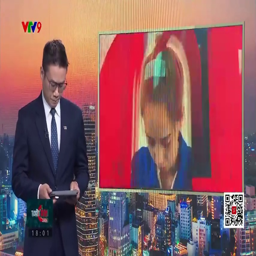

score: 0.0374
caption: a man in a suit and tie is standing in front of a large screen
objects: ['person', 'tie', 'tv']


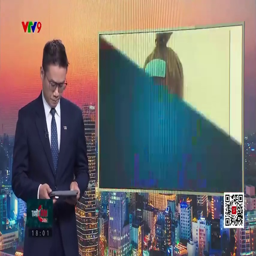

score: 0.0304
caption: a man in a suit and tie is standing in front of a tv screen
objects: ['person', 'tie']


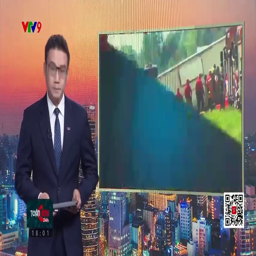

score: 0.0299
caption: a man in a suit and tie standing in front of a tv screen
objects: ['person', 'tie']


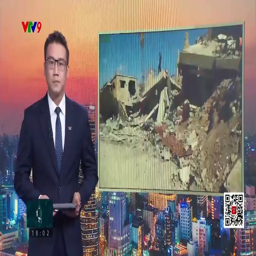

score: 0.0292
caption: a man in a suit and tie is sitting at a desk
objects: ['person', 'tie']


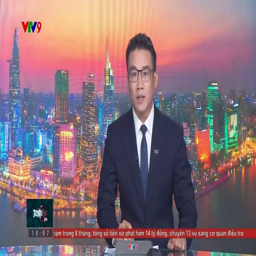

score: 0.0266
caption: a man in a suit and tie standing in front of a television screen
objects: ['person', 'tie', 'bowl', 'cup']


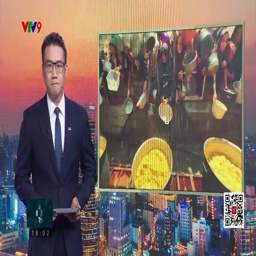

score: 0.0263
caption: a man in a suit and tie is sitting at a desk
objects: ['person', 'tie']


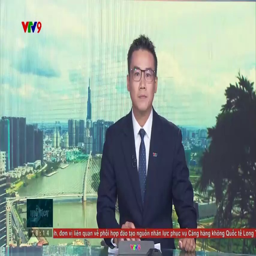

score: 0.0260
caption: a man in a suit and tie standing at a podium
objects: ['person', 'tie']


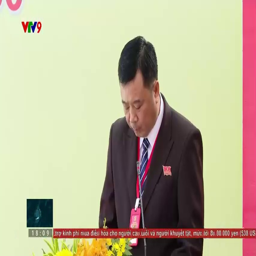

score: 0.0256
caption: a man in a suit and tie standing at a podium
objects: ['person', 'tie']


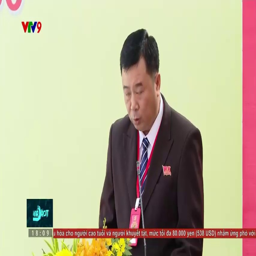

In [10]:
query_en, hits = search("người đàn ông trên vtv9 mặc suit", k=9, mode="fuse",
                        alpha_img=1, alpha_cap=1, alpha_obj=0.7,
                        fuse_method="rrf")
for r in hits:
    print(f"score: {r['score']:.4f}")
    print(f"caption: {r['caption']}")
    print(f"objects: {r['objects']}")
    display(Image.open(r['path']).resize((256, 256)))